# Solving A transverse field Ising model

In [1]:
using Yao
using Statistics: mean
using LinearAlgebra
using Plots

## Model Hamiltonians

### Transverse field Ising Model

$H = \sum\limits_{i=1}^{N-1} s_i^z s^z_{i+1} + h\sum\limits^{N}_{i=1} s_i^x$

where $s^\alpha = \frac 1 2 \sigma^\alpha$ is the spin operator.

In [38]:
"""
for simplicity, we require an AbstractModel contains `size` and `periodic` members.
"""
abstract type AbstractModel{D} end

nspin(model::AbstractModel) = prod(model.size)

nspin (generic function with 1 method)

In [39]:
"""
transverse field ising model, `h` is the strength of transverse field.
"""
struct TFI{D} <:AbstractModel{1}
    size::NTuple{D, Int}
    h::Float64
    periodic::Bool
    TFI(size::Int...; h::Real, periodic::Bool) = new{length(size)}(size, Float64(h), periodic)
end

TFI

In [40]:
"""
get the bonds of a chain model.
"""
function get_bonds(model::AbstractModel{1})
    nbit, = model.size
    [(i, i%nbit+1) for i in 1:(model.periodic ? nbit : nbit-1)]
end

get_bonds

In [41]:
"""
Get the hamiltonian of a TFI model
"""
function hamiltonian(model::TFI)
    nbit = nspin(model)
    sum(repeat(nbit, Z, (i,j)) for (i,j) in get_bonds(model))*0.25 +
    sum(put(nbit, i=>X) for i=1:nbit)*0.5model.h
end

hamiltonian

In [42]:
tfi_model = TFI(4; h=0.5, periodic=false)

TFI{1}((4,), 0.5, false)

In [43]:
tfi_h = hamiltonian(tfi_model)

nqubits: 4, datatype: Complex{Float64}
sum
├─ [scale: 0.25] sum
│     ├─ repeat on (1, 2)
│     │  └─ Z gate
│     ├─ repeat on (2, 3)
│     │  └─ Z gate
│     └─ repeat on (3, 4)
│        └─ Z gate
└─ [scale: 0.25] sum
      ├─ put on (1)
      │  └─ X gate
      ├─ put on (2)
      │  └─ X gate
      ├─ put on (3)
      │  └─ X gate
      └─ put on (4)
         └─ X gate


# A quantum circuit as an ansatz

Construct the following circuit as our ansatz

<div style="display:inline-block"><img style="float:left", src="images/fourqubit.png" width="500"></div>

In [92]:
Rxz() = chain(Rx(0.0), Rz(0.0))
MeasureAndReset(nbit::Int, i::Int) = Measure{nbit, 1, AbstractBlock}(Z, (i,), 0, false)

function ansatz_circuit(nbit::Int, d::Int)
    circuit = chain(nbit)

    for i=1:nbit-1
        unit = chain(nbit)
        for j=1:d
            push!(unit, put(nbit, i=>Rxz()))
            push!(unit, put(nbit, nbit=>Rxz()))
            push!(unit, control(nbit, 1, 2=>shift(0.0)))
        end
        push!(circuit, unit)
    end
    push!(circuit, chain([MeasureAndReset(nbit, i) for i=1:nbit]))
    circuit
end

ansatz_circuit (generic function with 1 method)

In [93]:
example_circuit = ansatz_circuit(4, 1)

nqubits: 4, datatype: Complex{Float64}
chain
├─ chain
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.0)
│  │     └─ rot(Z gate, 0.0)
│  ├─ put on (4)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.0)
│  │     └─ rot(Z gate, 0.0)
│  └─ control(1)
│     └─ (2,) shift(0.0)
├─ chain
│  ├─ put on (2)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.0)
│  │     └─ rot(Z gate, 0.0)
│  ├─ put on (4)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.0)
│  │     └─ rot(Z gate, 0.0)
│  └─ control(1)
│     └─ (2,) shift(0.0)
├─ chain
│  ├─ put on (3)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.0)
│  │     └─ rot(Z gate, 0.0)
│  ├─ put on (4)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.0)
│  │     └─ rot(Z gate, 0.0)
│  └─ control(1)
│     └─ (2,) shift(0.0)
└─ chain
   ├─ Measure(4;operator=Z gate, locs=(1,), collapseto=0)
   ├─ Measure(4;operator=Z gate, locs=(2,), collapseto=0)
   ├─ Measure(4;operator=Z gate, locs=(3,), collapseto=0)
   └─ Measure(4;operator=Z gate, locs=(4,), collapseto=0)


In [94]:
nparameters(example_circuit)

15

In [95]:
"""
    gensample(circuit, operator; nbatch=1024) -> Vector of Measure

Generate samples from MPS-inspired circuit. Here, `nbatch` means nshot.
`operator` is the operator to measure.
This function returns a vector of `Measure` gates, results are stored in `m.results`.
"""
function gensample(circuit, operator; nbatch=1024)
    mblocks = collect_blocks(Measure, circuit)
    for m in mblocks
        m.operator = operator
    end
    reg = zero_state(nqubits(circuit); nbatch=nbatch)
    reg |> circuit
    mblocks
end

gensample

In [96]:
res = gensample(example_circuit, X; nbatch=1024)

4-element Array{Measure,1}:
 Measure(4;operator=X gate, locs=(1,), collapseto=0)
 Measure(4;operator=X gate, locs=(2,), collapseto=0)
 Measure(4;operator=X gate, locs=(3,), collapseto=0)
 Measure(4;operator=X gate, locs=(4,), collapseto=0)

In [91]:
res[1].results

1024-element Array{Int64,1}:
  1
  1
  1
 -1
  1
 -1
 -1
  1
  1
 -1
 -1
  1
 -1
  ⋮
  1
  1
 -1
 -1
 -1
 -1
 -1
  1
  1
  1
 -1
  1

In [50]:
"""
    VQE{MT, BT<:AbstractBlock}

Variational quantum eigensolver setup
* `MT` is the type of hamiltonian model,
* `BT` is the type of an input circuit.
"""
struct VQE{MT, BT<:AbstractBlock}
    model::MT
    circuit::BT
    nshots::Int
end

VQE(model, circuit::AbstractBlock; nshots::Int=1024) = VQE(model, circuit, nshots)

VQE

## Loss Function

$$\langle H\rangle = \mathbb{E}_{k}\left[\frac{J}{4}(\sum_i Z_i^{(k)} Z_{i+1}^{(k)}) + \frac{h}{2}\sum_i X_i^{(k)}\right]$$

In [55]:
"""
Obtain the energy of a VQE application.
"""
function energy(vqe::VQE{<:TFI})
    # measuring Z
    eng = ising_energy(vqe.circuit, get_bonds(vqe.model), Z; nshots=vqe.nshots)
    # measuring transverse field term on basis X
    mblocks = gensample(vqe.circuit, X; nbatch=vqe.nshots)
    engx = sum(mean.([m.results for m in mblocks]))
    eng + vqe.model.h*engx/2
end

function ising_energy(circuit, bonds, basis; nshots::Int)
    mblocks = gensample(circuit, basis; nbatch=nshots)
    nspin = length(mblocks)
    local eng = 0.0
    for (a, b) in bonds
        eng += mean(mblocks[a].results .* mblocks[b].results)
    end
    eng/=4
end

ising_energy (generic function with 1 method)

In [56]:
# obtain the energy through sampling
vqe = VQE(tfi_model, example_circuit; nshots=1024)
dispatch!(vqe.circuit, :random)
energy(vqe)

0.755859375

In [57]:
wave_function(circuit) = zero_state(nqubits(circuit)) |> circuit[1:end-1]

wave_function (generic function with 1 method)

In [59]:
# obtain the exact <H> through wave function
energy_exact(vqe) = expect(hamiltonian(vqe.model), wave_function(vqe.circuit)) |> real
energy_exact(vqe)

0.7522941997757429

## Training

Sequential optimization
1. obtain the gradient of parameters $\frac{\partial E_\theta}{\partial \theta} = \frac 1 2 (E_{\theta+\pi/2}-E_{\theta-\pi/2})$
2. feed gradient descents into Adam $\theta\rightarrow \theta-\tilde{\alpha}_{\rm history} \frac{\partial E_\theta}{\partial \theta}$
3. update parameters and repeat until convergence.

In [97]:
"""
obtain the gradient of a parameter in a rotation gate/cphase gate.
"""
function opgrad(vqe::VQE, r)
    dispatch!(+, r, π/2)
    E₊ = energy(vqe)
    dispatch!(-, r, π)
    E₋ = energy(vqe)
    dispatch!(+, r, π/2)
    0.5*(E₊ - E₋)
end

opgrad

In [98]:
using Flux: ADAM, Optimise

In [99]:
function train!(vqe::VQE; maxiter::Int=200, α::Real=0.3)
    circuit, model = vqe.circuit, vqe.model
    rots = collect_blocks(Union{RotationGate, ControlBlock{<:Any, <:ShiftGate}}, circuit)
    loss_history = Float64[]
    params = vcat(parameters.(rots)...)
    optimizer = ADAM(α)
    for i in 0:maxiter
        grad = opgrad.(Ref(vqe), rots)
        Optimise.update!(optimizer, params, grad)
        dispatch!.(rots, params)
        push!(loss_history, energy_exact(circuit, model, nbatch=nbatch)/nspin(model))
        
        i%10 == 0 && println("Iter $i, E/N = $(loss_history[end])")
    end
    loss_history, circuit
end

train! (generic function with 1 method)

In [100]:
lattice_size = 4
vqe = VQE(TFI(lattice_size; h=0.5, periodic=false),
    ansatz_circuit(lattice_size, 2);
    nshots=1024);

In [101]:
# obtain the exact ground state energy
res = eigen(mat(hamiltonian(vqe.model)) |> Matrix)
EG = res.values[1]/nspin(model)
@show EG
VG = res.vectors[:,1];

EG = -0.29742315519647605


In [103]:
dispatch!(vqe.circuit, :random)
loss_history, circuit = train!(vqe; maxiter=100, α=0.3);

Iter 0, E/N = -0.024362648897917914
Iter 10, E/N = -0.2191401252410583
Iter 20, E/N = -0.2719215791264804
Iter 30, E/N = -0.2744586282675524
Iter 40, E/N = -0.276446838077148
Iter 50, E/N = -0.278109919941845
Iter 60, E/N = -0.27827321382642983
Iter 70, E/N = -0.2780798319532818
Iter 80, E/N = -0.2776838176833727
Iter 90, E/N = -0.27757620223804014
Iter 100, E/N = -0.27764366354257947


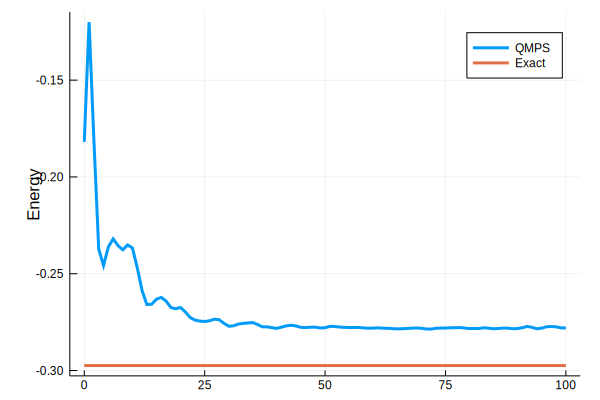

In [85]:
M = length(loss_history)
plot(0:M-1, [loss_history, fill(EG, M)], label=["QMPS", "Exact"], lw=3, ylabel="Energy")

## Quantum circuit inspired by an MPS

Hadamard Gate with dashed box is applied only when measuring on the X basis.
<div style="display:inline-block"><img style="float: left", src="images/hgate.png" width="50"/></div>

The following gates Measure and Reset a qubit to 0.

<div style="display:inline-block"><img style="float:left", src="images/mreset.png" width="100"></div>

The goal of this section is to build the MPS-inspired sampler as our ansatz

<div style="display:inline-block"><img style="float:left", src="images/twoqubit.png"></div>

### Reference: Variational Quantum Eigensolver with Fewer Qubits

*Jin-Guo Liu, Yi-Hong Zhang, Yuan Wan, Lei Wang*

https://arxiv.org/abs/1902.02663

In [369]:
"""
    ansatz_circuit(nlayer::Int, nrepeat::Int)

Construct the above ansatz, `nrepeat` is the number of measure operations,
`nlayer` is the length of each block.
"""
function ansatz_circuit(nbit::Int, d::Int, nrepeat::Int)
    nbit_measure = nbit_virtual = 1
    nbit_used = nbit_measure + nbit_virtual
    circuit = chain(nbit_used)

    for i=1:nrepeat
        unit = chain(nbit_used)
        #push!(unit, put(nbit_used, 2=>H))
        for j=1:d
            push!(unit, put(nbit_used, 1=>Rxz()))
            push!(unit, put(nbit_used, 2=>Rxz()))
            push!(unit, control(nbit_used, 1, 2=>shift(0.0)))
        end
        push!(unit, MeasureAndReset())
        if i==nrepeat
            for k=2:nbit_used
                push!(unit, MeasureAndReset())
            end
        end
        push!(circuit, unit)
    end
    dispatch!(circuit, :random)
end

twoqubit_circuit

In [370]:
circuit = ansatz_circuit(1, 3)

nqubits: 2, datatype: Complex{Float64}
chain
├─ chain
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.21095863334236697)
│  │     └─ rot(Z gate, 0.7061513298045752)
│  ├─ put on (2)
│  │  └─ H gate
│  ├─ put on (2)
│  │  └─ rot(Z gate, 0.606758675085191)
│  ├─ control(1)
│  │  └─ (2,)shift(0.8692942974976297)
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.9742930709729192)
│  │     └─ rot(Z gate, 0.2511950574828521)
│  ├─ put on (2)
│  │  └─ H gate
│  ├─ put on (2)
│  │  └─ rot(Z gate, 0.8950395744932531)
│  └─ Measure{2,1,AbstractBlock}
├─ chain
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.8280959771285328)
│  │     └─ rot(Z gate, 0.6397794287466416)
│  ├─ put on (2)
│  │  └─ H gate
│  ├─ put on (2)
│  │  └─ rot(Z gate, 0.43658892015653006)
│  ├─ control(1)
│  │  └─ (2,)shift(0.22277943843476922)
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.6583878015555824)
│  │     └─ rot(Z gate, 0.054800922397594265)
│  ├─ put on (2)
│  │  └─ H gate
│ 

## Using the finite difference method, see what will happen

In [80]:
function numgrad(vqe::VQE, r; δ=0.01)
    dispatch!(+, r, (δ/2,))
    E₊ = energy(vqe)
    dispatch!(-, r, (δ,))
    E₋ = energy(vqe)
    dispatch!(+, r, (δ/2,))
    (E₊ - E₋)/δ
end

numgrad (generic function with 2 methods)